In [6]:
import camb
import numpy as np
import matplotlib.pylab as plt
import glob
import time
import corner

In [7]:
glob.glob("./*")

['./obj',
 './A5.ipynb',
 './COM_PowerSpect_CMB-TT-binned_R3.01.txt',
 './planck_chain.txt',
 './COM_PowerSpect_CMB-TT-full_R3.01.txt',
 './planck_chain_tauprior.txt',
 './planck_fit_params.txt']

# Data
The four columns contains multipole, variance, lower & upper errorbars.

We look at multipoles from 2 to 2508. (I guess that for higher multipoles, we are looking at higher angular scales).

In [8]:
dat = np.loadtxt("COM_PowerSpect_CMB-TT-full_R3.01.txt")
dat.shape

(2507, 4)

# Question a)
### Try to understand the script

CAMB model parameters

source: 
>https://camb.readthedocs.io/en/latest/model.html \
>https://camb.readthedocs.io/en/latest/CAMBdemo.html

Essentially:
* set I.C. for cosmological conditions
* set initial power spectrum params
* set max multipole we want
* calculate specific parameters (including power spectra)
* get total power spectra (shaped `(lmax,4)`)

In [5]:
# parameters for power spectrum model
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
# load data
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
# scale
ell=planck[:,0]
# variance
spec=planck[:,1]
# avg. errorbar
errs=0.5*(planck[:,2]+planck[:,3]);


In [6]:
def get_spectrum(pars,lmax=3000):
    # hubble
    H0=pars[0]
    # density of regular baryons
    ombh2=pars[1]
    # Omega_cdm: density of cold dark matter
    omch2=pars[2]
    # Thompson scattering optical depth
    tau=pars[3]
    ## "Amplitude and tilt of init. power spectrum"
        # comoving curvature power at k=pivot_scalar 
    As=pars[4]
        # scalar spectral index 
    ns=pars[5]
    
    pars=camb.CAMBparams()

        # mnu: sum of neutrino masses 
        # omk: Omega_k curvature parameter
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    
        # r:  tensor to scalar ratio at pivot
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    
    # Set parameters to get CMB power spectra accurate to specific a l_lmax. 
            # this does not fix the actual output L range, 
            # spectra may be calculated above l_max (but may not be accurate there).
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    
    # Calculate results for specified parameters and return CAMBdata instance
    results=camb.get_results(pars)
    
    powers = results.get_cmb_power_spectra(pars,CMB_unit='muK')
    
    # alternatively ('unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential')
    cmb = powers['total']
    
    tt = cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    
    # we only have multipls from 2
    return tt[2:]



chisq is  15267.937435709791  for  2501  degrees of freedom.


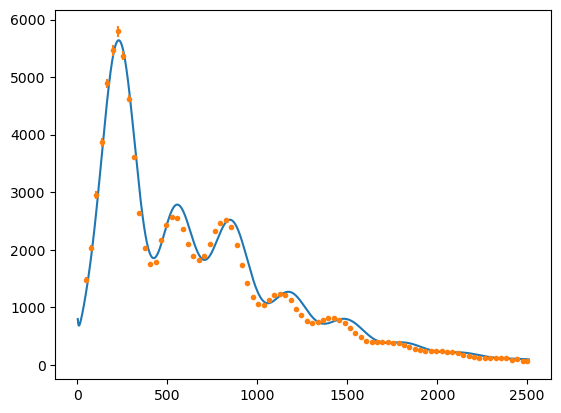

In [7]:
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec - model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
# read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);

plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

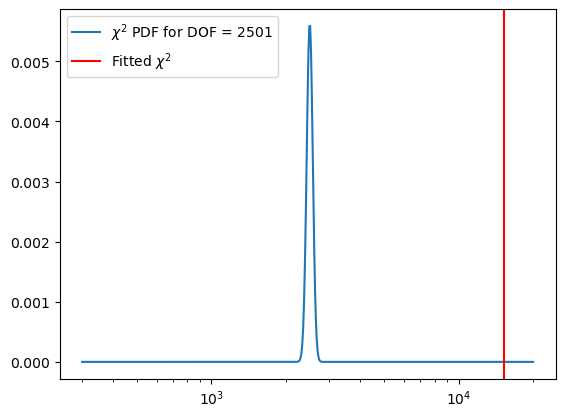

In [8]:
from scipy.stats import chi2

x_chi = np.linspace(300,20000,1000)
plt.plot(x_chi, chi2.pdf(x_chi, len(resid)-len(pars)), 
         label = f"$\chi^2$ PDF for DOF = {len(resid)-len(pars)}")
plt.axvline(chisq,c='r', label = "Fitted $\chi^2$")
plt.xscale('log')
plt.legend()

In [9]:
chi2.sf(chisq, len(resid)-len(pars))

0.0

The likelihood of observing such $\chi^2$ value given our input data is essentially zero from the survival function.
## The fit is **unacceptable**.

In [10]:
pars = np.array([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec - model
chisq2=np.sum( (resid/errs)**2)
dof = len(resid) - len(pars)

In [11]:
print("First set of params:", chisq, '\nwith survival value:' , chi2.sf(chisq, dof),"\n")
print("Second set of params:", chisq2, '\nwith survival value:' , chi2.sf(chisq2, dof))
print(f'\nMEAN: {dof} +/- {np.sqrt(2*dof)}')
print("\nchi^2 value, below which is 90% acceptable: ", chi2.isf(.9,  dof))


First set of params: 15267.937435709791 
with survival value: 0.0 

Second set of params: 3272.2036739044693 
with survival value: 1.149548163599582e-23

MEAN: 2501 +/- 70.7248188403477

chi^2 value, below which is 90% acceptable:  2410.8015270308797


The new $\chi^2$ value of **3272.2** is lower. However, it is still far from accepting the null hypothesis.\
Given that the survival probability is `~1e-23`, this new set of `pars` is still **unacceptable.**\
Our target is at least below `2501`.

# Question b): Implementing Numerical Derivatives
Stealing my own code (and adapting to this assignment). 


In [12]:
def Ndiff(f, x, dx_list):
    diffs = []

    for i in range(len(x)):
        one_idx = np.zeros(len(x))
        one_idx[i] += 1
        
        dx = dx_list[i]
        
        x_2m = x.copy()
        x_m  = x.copy()
        x_p  = x.copy()
        x_2p = x.copy()
        x_2m -= 2 *dx * one_idx
        x_m  -= dx * one_idx
        x_p  += dx * one_idx
        x_2p += 2*dx * one_idx
        
        diffs.append((f(x_2m) + 8 * f(x_p) - 8 * f(x_m) - f(x_2p))/(12 * dx))

    return np.array(diffs)

In [13]:
def calc_spec(params, lmax = 3000):
    # returns the spectrum as well as the gradient w.r.t. the parameters at input <p>
    f = lambda params: get_spectrum(params, lmax)
    y = f(params)
    grad = np.zeros([lmax, len(params)])
    grad = Ndiff(f, params, dx).transpose()
    
    return  y, grad


Because the curvature can be not $~O(1)$, we have to set the stepsizes in each parameter differently instead of assuming an uniform `dx`.\
**The differentiation takes up most of the time because we have to take gradient at 2507 points along 6 directions.**

In [14]:
dx = pars *1e-3

### Levenberg-marquardt
The result comes from more than 30 iterations. The last 20 iterations didn't update the result. We suspect that the NLS fitting has converged.

In [15]:
def calc_chi(y):
    return np.sum((y - spec)**2/errs**2)

def update(damping, success):
    # if all goes well...
    if success:
        damping *= .3
        if damping <= 0.1:
            damping = 0
    else:
        if damping == 0:
            damping = 1
        else:
            damping *= 2
            
    return damping



In [16]:
# np.save('obj/fit_p.npy', pars)
# info = [10,1e9,True]
# np.save('obj/info.npy', info)

### Here we print:
* damping after last iteration
* params after last iteration
* Whether or not $\chi^2 $ is less than old value

In [17]:
steps = 10

p0 = np.load('obj/fit_p.npy')
p = np.array(p0.copy())

invN = np.diag(1/errs**2)

damping, chisq, success = np.load('obj/info.npy')

In [252]:
for i in range(steps):
    print("parmas: ".rjust(30), p)
    print("damping: ".rjust(30), damping)
    
    pred, grad = calc_spec(p)
    pred = pred[:len(spec)] 
    grad = np.matrix(grad)[:len(spec),:]
    
    r = spec - pred
    r = np.matrix(r).transpose()
    
    lhs = grad.transpose() @ invN @ grad
    
    curv_mat = np.linalg.inv(lhs)
    
    lhs += damping * np.diag(np.diag(grad.transpose() @ invN @ grad))
    
    rhs = grad.transpose() @ invN @ r

    dp = np.linalg.inv(lhs)@(rhs)
    
    p_new = p.copy()
    
    for j in range(len(p)):
        p_new[j] = p[j] + dp[j]
        
    new_chisq = calc_chi(get_spectrum(p_new)[:len(spec)])
    
    if new_chisq < chisq:
        success = True
        chisq = new_chisq
        p = p_new
        damping = update(damping, success)

    else:
        success = False
        damping = update(damping, success)
    
    print(np.sqrt(np.diag(curv_mat)))
    print("success: ".rjust(30), success,"\n")
    
    
    np.save('obj/fit_p.npy', p)
    np.save('obj/fit_curvmat.npy', curv_mat)
    np.save('obj/info.npy', [damping, chisq, success])

                      parmas:  [6.78789164e+01 2.23151582e-02 1.18465150e-01 5.85254433e-02
 2.10767833e-09 9.70995108e-01]
                     damping:  1
[1.17354613e+00 2.30185089e-04 2.63700816e-03 3.64604161e-02
 1.46637861e-10 6.37003260e-03]
                     success:  True 

                      parmas:  [6.78777988e+01 2.23142381e-02 1.18464882e-01 5.85338602e-02
 2.10769893e-09 9.71000762e-01]
                     damping:  0.3
[1.17355122e+00 2.30184341e-04 2.63708815e-03 3.64636829e-02
 1.46650114e-10 6.36839407e-03]
                     success:  True 

                      parmas:  [6.78751114e+01 2.23123383e-02 1.18465419e-01 5.85587851e-02
 2.10778031e-09 9.71009865e-01]
                     damping:  0
[1.17400299e+00 2.30191737e-04 2.63817276e-03 3.64326459e-02
 1.46522166e-10 6.37087802e-03]
                     success:  False 

                      parmas:  [6.78751114e+01 2.23123383e-02 1.18465419e-01 5.85587851e-02
 2.10778031e-09 9.71009865e-01]
         

In [18]:
p = np.load('obj/fit_p.npy')
curv_mat = np.load('obj/fit_curvmat.npy')

In [20]:
p_names = ['Hubble', "Baryon", "CDM", "Optical Depth", "P.S. Amp.", "P.S. Tilt"]
p_err = np.sqrt(np.diag(curv_mat))
for i, n in enumerate(p_names):
    print(f"{n} = ".ljust(20), f"{p[i]:.2E}", "+/-", f"{p_err[i]:.2E}")

Hubble =             6.79E+01 +/- 1.17E+00
Baryon =             2.23E-02 +/- 2.31E-04
CDM =                1.18E-01 +/- 2.64E-03
Optical Depth =      5.86E-02 +/- 3.64E-02
P.S. Amp. =          2.11E-09 +/- 1.46E-10
P.S. Tilt =          9.71E-01 +/- 6.38E-03


In [320]:
fit_string = []

p_names = ['Hubble', "Baryon", "CDM", "Optical Depth", "P.S. Amp.", "P.S. Tilt"]
p_err = np.sqrt(np.diag(curv_mat))
for i, n in enumerate(p_names):
    fit_string.append(f"{n} = ".ljust(20)+f"{p[i]:.2E}"+ " +/- "+ f"{p_err[i]:.2E}\n")

In [325]:
np.savetxt('planck_fit_params.txt', fit_string, delimiter="\n", fmt="%s")

# Question c) MCMC
We draw our **trial step sizes** from the curvature matrix above based on a Gaussian distribution with $\sigma_{stepsize}$.

It takes about 0.71 seconds to run one step. Most of the time is spent calculating `results` and obtaining the power spectrum within the `CAMB` package.

In [228]:
# pp = pars.copy()
pp = np.load('obj/chain.npy')[-1]
steps = 5000
scaling = .8

# chisqr = calc_chi(get_spectrum(pp)[:len(spec)])
chisqr = np.load('obj/chiChain.npy')[-1]

# # # Initiate new run
chain = np.zeros([steps, len(pp)])
chiChain = np.zeros(steps)

### Generating perturbative steps
Use multivariate with covariance matrix to generate error. \
Same as doing np.linalg.cholesky(curv_mat)@ np.random.randn(6)

In [229]:
t1 = time.time()
for s in np.arange(steps):
    # generate steps
    p_new = pp + np.random.multivariate_normal(mean = np.zeros(len(curv_mat)), cov = curv_mat) * scaling
    new_chi2 = calc_chi(get_spectrum(p_new)[:len(spec)])
    del_chi = new_chi2 - chisqr
    
    take = None
    
    if del_chi >= 0 :
        if np.random.rand() < np.exp(- 0.5 * del_chi):
            take = True
        else:
            take = False
            
    else:
        take = True
    
    if take == True:
        pp = p_new            
        chisqr = new_chi2
        
    chiChain[s] = chisqr
    chain[s, :] = pp
    
    # print module
    if s%1000==0:
        print(s)
        print(pp)
        
t2 = time.time()

0
[6.82603137e+01 2.23918260e-02 1.17444071e-01 4.19451261e-02
 2.03745233e-09 9.69858981e-01]
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
1000
[6.75414662e+01 2.23768877e-02 1.20551481e-01 7.12161607e-02
 2.17244809e-09 9.67914584e-01]
 Check 

In [232]:
# test_chiChain = np.hstack([np.load('obj/chiChain.npy'), chiChain])
# test_chain = np.vstack([np.load('obj/chain.npy'), chain])

In [309]:
# np.save('obj/chain.npy', chain)
# np.save('obj/chiChain.npy', test_chiChain)
# chain = np.load('obj/chain.npy')[:9000]
# chiChain = np.load('obj/chiChain.npy')

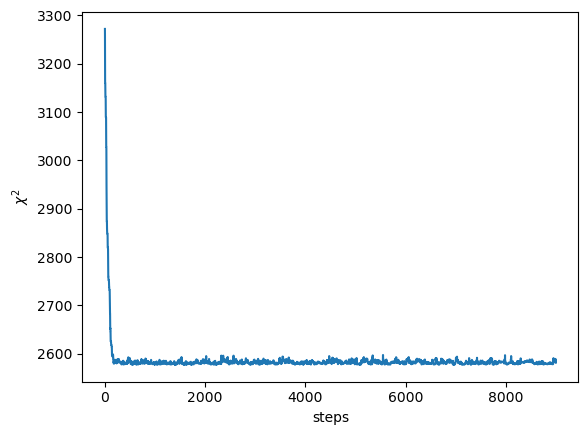

In [245]:

plt.plot(chiChain)
plt.ylabel("$\chi^2$")
plt.xlabel("steps")
plt.show()

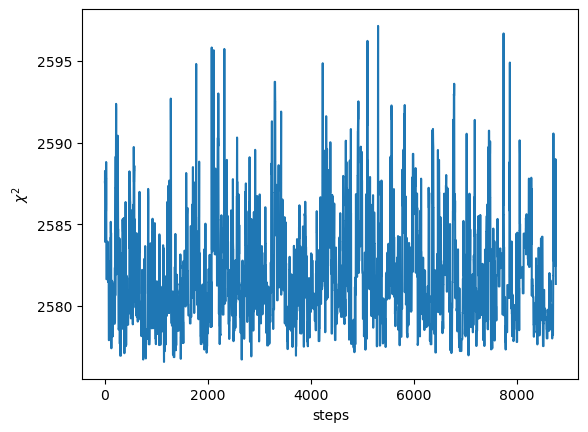

In [246]:
plt.plot(chiChain[250:])
plt.ylabel("$\chi^2$")
plt.xlabel("steps")
plt.show()

Text(0.5, 0, 'steps')

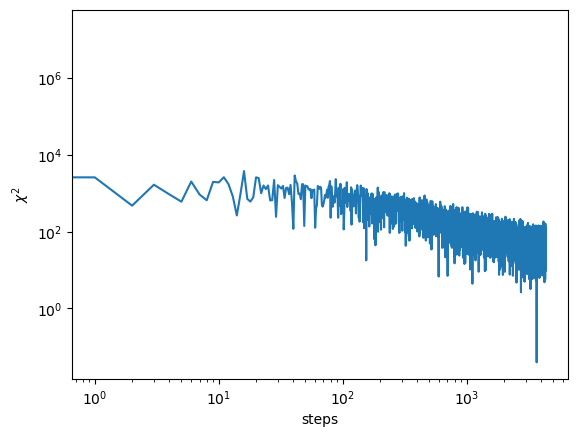

In [247]:
plt.loglog(np.abs(np.fft.rfft(chiChain[300:])))
plt.ylabel("$\chi^2$")
plt.xlabel("steps")

### c) Chain Convergence
Looking at FFT of the variables, we see that the spectrum is independent of frequency up to around $\frac{10000}{100}=100$ steps, below which we see local correlated noise.\
The fourth and fifth variables are correlated, and their convergence is weaker than the others (to be dealt with in Question 4)

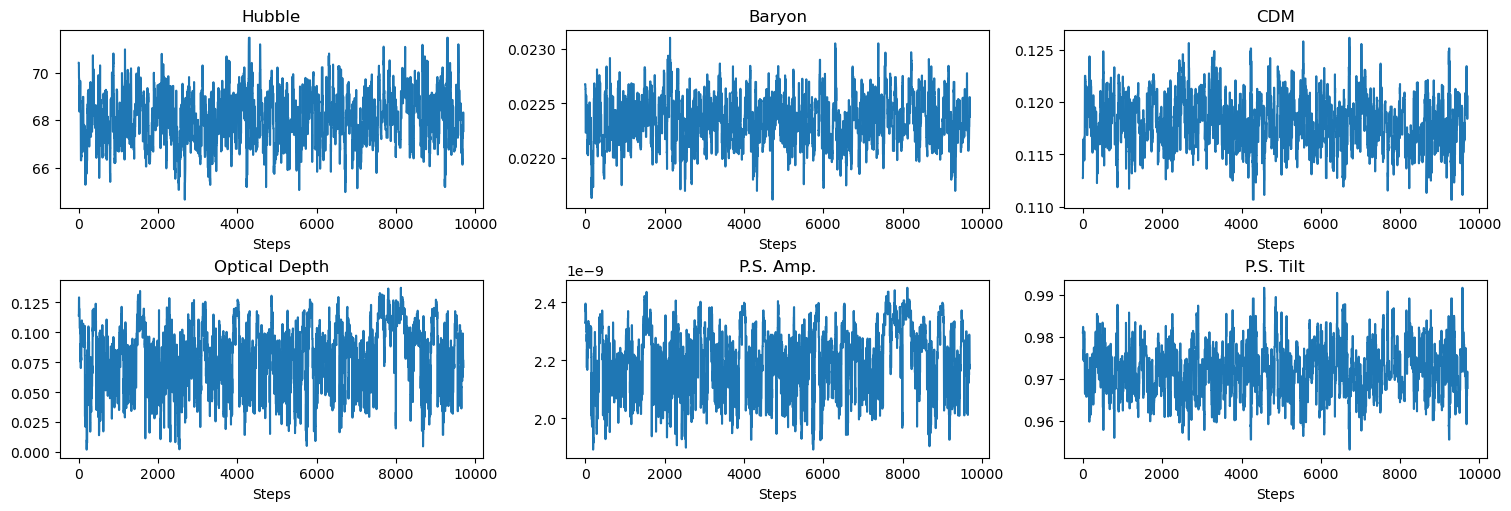

In [248]:
fig = plt.figure(figsize = (15,5),constrained_layout = True)
axes = fig.subplots(2,3).flatten()

for i in np.arange(6):
    axes[i].plot(chain[300:, i])
    axes[i].set_xlabel('Steps')
    axes[i].set_title(f"{p_names[i]}")

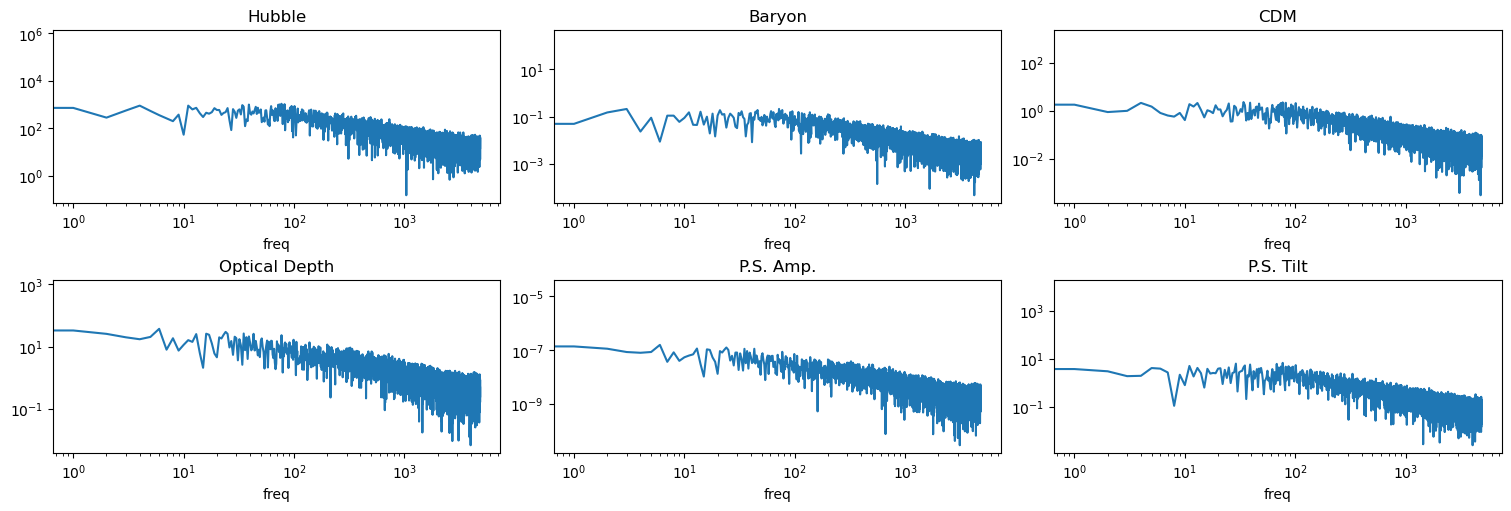

In [249]:
fig = plt.figure(figsize = (15,5),constrained_layout = True)
axes = fig.subplots(2,3).flatten()

for i in np.arange(6):
    axes[i].loglog(np.abs(np.fft.rfft(chain[300:, i])))
    axes[i].set_xlabel('freq')
    axes[i].set_title(f"{p_names[i]}")

## Reasonable rejection rate
Between $20\%-25\%$

In [250]:
# rejected steps
acc_rate = (len(chain) - np.sum(np.logical_and(np.diff(chain[:,0])==0,np.diff(chain[:,1])==0)))/len(chain)

print('Acceptance rate is :', acc_rate)

Acceptance rate is : 0.2486


## Corner Plots

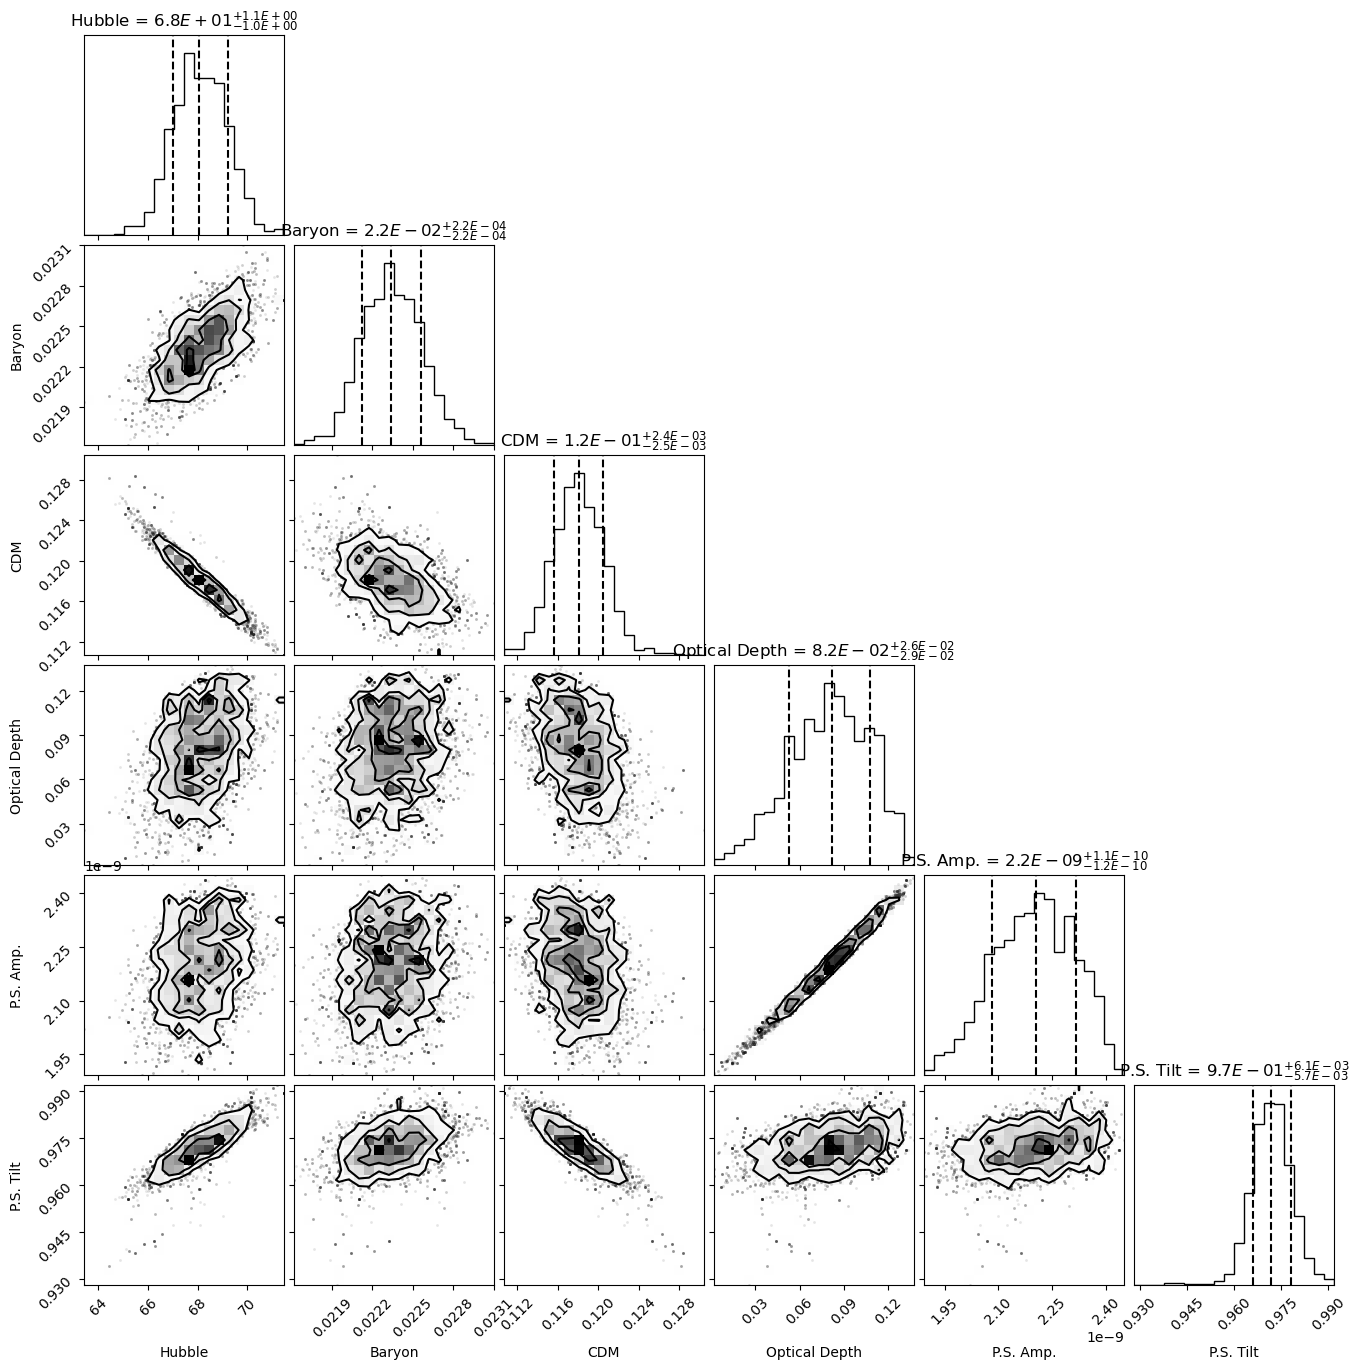

In [251]:
plt.ioff()
corner.corner(chain,
    labels=p_names, quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_fmt = '.1E')

## Compute the output variables 

In [252]:
mp = np.mean(chain, axis = 0)
mp_err = np.std(chain,axis = 0)

## Dark energy
For a critical universe, $\Omega_b+\Omega_c+\Omega_\Lambda = 1$.

$$h = H_0/100$$

$$\Omega_b = \text{Baryon}/h^2$$

$$\varepsilon(\Omega_b) = \sqrt{\frac{1}{h^4}\sigma_{\text{Baryon}}^2 + \frac{4*\text{Baryon}^2}{h^6}\sigma_{h}^2}$$
$$\varepsilon(\Omega_c) = \sqrt{\frac{1}{h^4}\sigma_{\text{D.M.}}^2 + \frac{4*\text{D.M.}^2}{h^6}\sigma_{h}^2}$$

### Result: $\Omega_\Lambda = 0.70 +/- 0.02$ (dim.less)

In [253]:
h = mp[0]/100
eh = mp_err[0]/100
Ob = mp[1]/h**2
eOb = np.sqrt(1/h**4 *mp_err[1]**2 + 4*Ob**2/h**6 * eh**2)
Oc = mp[2]/h**2
eOc = np.sqrt(1/h**4 *mp_err[2]**2 + 4*Oc**2/h**6 * eh**2)

Ol = 1 - Ob - Oc
eOl = np.sqrt(eOc**2 + eOb**2)

In [254]:
print("Dark energy = ", f"{Ol:.2f}", "+/-", f"{eOl:.2f}")

Dark energy =  0.70 +/- 0.02


# Problem 4
## Tau Prior
Use $\frac{1}{\chi^2}$ as weight to sampling the prvious chain. Calculate covariance with this weight from the previous chain using numpy.cov.
Generate new run with this covariance, evaluate new $\chi^2=\chi^2_{fit}+\chi^2_\tau$ 


In [84]:
tau = .0540
e_tau = .0074

# Importance sampling
Weight associated with each step in the MCMC chain is:
$$ w=\sqrt{\frac{\sigma_{\tau}^2}{(\tau_\text{obs.}-\mathbb{E}[\tau])^2}}$$\
Using this prior information we can calculate the mean and the covariance again.

In [197]:
w = 1/np.sqrt(((chain[:,3] - tau)**2/e_tau**2))
ip = np.average(chain, axis = 0, weights = w)
prior_cov = np.cov(chain.T, aweights = w)
ip_err = np.sqrt(np.diag(prior_cov))

p_names = ['Hubble', "Baryon", "CDM", "Optical Depth", "P.S. Amp.", "P.S. Tilt"]
print("IMPORTANCE SAMPLING:")
for i, n in enumerate(p_names):
    print(f"\t{n} = ".ljust(20), f"{ip[i]:.2E}", "+/-", f"{ip_err[i]:.2E}")

p_names = ['Hubble', "Baryon", "CDM", "Optical Depth", "P.S. Amp.", "P.S. Tilt"]

print("\n\nFitting:")
for i, n in enumerate(p_names):
    print(f"\t{n} = ".ljust(20), f"{p[i]:.2E}", "+/-", f"{p_err[i]:.2E}")


IMPORTANCE SAMPLING:
	Hubble =            6.88E+01 +/- 1.23E+00
	Baryon =            2.25E-02 +/- 2.26E-04
	CDM =               1.17E-01 +/- 2.79E-03
	Optical Depth =     5.49E-02 +/- 6.24E-03
	P.S. Amp. =         2.08E-09 +/- 2.99E-11
	P.S. Tilt =         9.75E-01 +/- 7.06E-03


Fitting:
	Hubble =            6.79E+01 +/- 1.17E+00
	Baryon =            2.23E-02 +/- 2.31E-04
	CDM =               1.18E-01 +/- 2.64E-03
	Optical Depth =     5.86E-02 +/- 3.64E-02
	P.S. Amp. =         2.11E-09 +/- 1.46E-10
	P.S. Tilt =         9.71E-01 +/- 6.38E-03


# MCMC with Covariance Drawn from Importance Sampling

In [219]:
pp = pars.copy()
# pp = np.load('obj/tau_chain.npy')[-1]
steps = 10000
scaling = .78

chisqr = calc_chi(get_spectrum(pp)[:len(spec)])
# chisqr = np.load('obj/tau_chiChain.npy')[-1]

# Initiate new run
chain = np.zeros([steps, len(pp)])
chiChain = np.zeros(steps)

# Metropolis Hastings
Note that we can generate Gaussian steps with prior $\tau$ information from the new covariance matrix.\
However, we also need to change the acceptance function by encompassing the prior information.\
Therefore:
$$\chi^2_\text{new} = \chi^2_\text{fit} + \chi_{\tau}^2$$ since log-likelihood functions is additive. For joint probability of both the fit and tau, we simply add the $chi^2$ together.

In [220]:
for s in np.arange(steps):
    # generate steps
    p_new = pp + np.random.multivariate_normal(mean = np.zeros(len(curv_mat)), cov = prior_cov) * scaling
    new_chi2 = calc_chi(get_spectrum(p_new)[:len(spec)])
    
    del_chi = new_chi2 - chisqr + (p_new[3] - tau)**2/e_tau**2
    
    take = None
    
    if del_chi >= 0 :
        if np.random.rand() < np.exp(- 0.5 * del_chi):
            take = True
        else:
            take = False
            
    else:
        take = True
    
    if take == True:
        pp = p_new            
        chisqr = new_chi2
        
    chiChain[s] = chisqr
    chain[s, :] = pp
    
    # print module
    if s%500==0:
        print(s)
        print(pp)

        

0
[6.9e+01 2.2e-02 1.2e-01 6.0e-02 2.1e-09 9.5e-01]
500
[6.72294898e+01 2.22047141e-02 1.19827287e-01 7.43409750e-02
 2.19046423e-09 9.62907582e-01]
1000
[6.68712354e+01 2.23129297e-02 1.20719145e-01 6.23728762e-02
 2.13712683e-09 9.62719777e-01]
1500
[6.71217807e+01 2.22019659e-02 1.20322264e-01 6.09498271e-02
 2.12838451e-09 9.65580724e-01]
2000
[6.83007861e+01 2.24226102e-02 1.17234882e-01 5.68430663e-02
 2.09294206e-09 9.74948422e-01]
2500
[6.77218378e+01 2.22476185e-02 1.18313861e-01 5.54497653e-02
 2.09136127e-09 9.70671021e-01]
3000
[6.72179910e+01 2.21518403e-02 1.19206020e-01 6.00799071e-02
 2.12198561e-09 9.67394879e-01]
3500
[6.83811461e+01 2.23792206e-02 1.16963102e-01 5.61688723e-02
 2.09150026e-09 9.73032203e-01]
4000
[6.77595272e+01 2.21778874e-02 1.18727170e-01 4.91780250e-02
 2.06986206e-09 9.71074414e-01]
4500
[6.92855275e+01 2.23872723e-02 1.14856407e-01 4.06339020e-02
 2.01802306e-09 9.75517550e-01]
5000
[6.94902368e+01 2.27082352e-02 1.15363510e-01 5.39702784e-02
 

In [225]:
# np.save('obj/tau_chain.npy', chain)
# np.save('obj/tau_chiChain.npy', chiChain)

In [260]:
chain = np.load('obj/tau_chain.npy')
chiChain = np.load('obj/tau_chiChain.npy')

# Comparison of Results

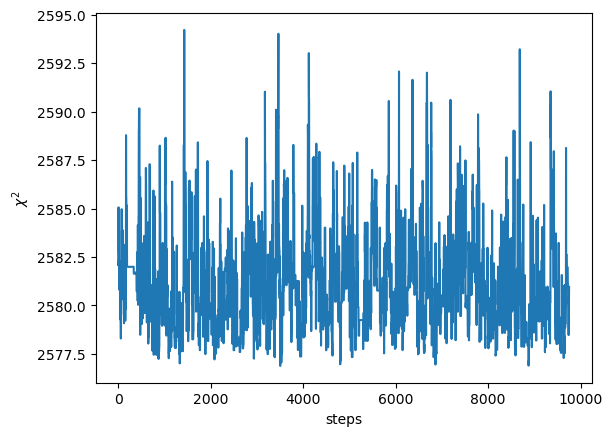

In [262]:
plt.plot(chiChain[250:])
plt.ylabel("$\chi^2$")
plt.xlabel("steps")
plt.show()

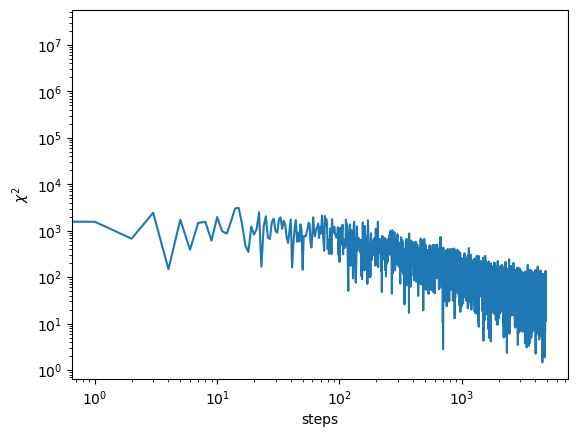

In [267]:
plt.loglog(np.abs(np.fft.rfft(chiChain[300:])))
plt.ylabel("$\chi^2$")
plt.xlabel("steps")
plt.show()

# Chain Convergence
Looking at FFT of the variables, we see that the spectrum is independent of frequency up to around $\frac{10000}{100}=100$ steps, below which we see local correlated noise.\
The fourth and fifth variables are correlated, and their convergence is weaker than the others (to be dealt with in Question 4)

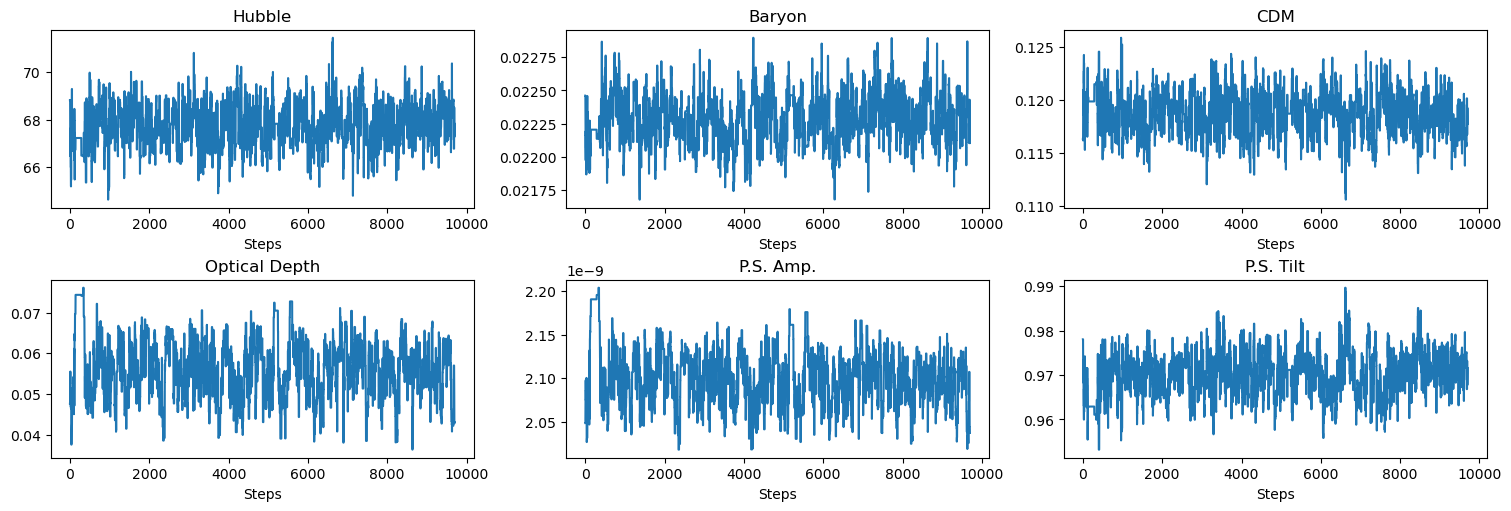

In [273]:
plt.ion()
fig = plt.figure(figsize = (15,5),constrained_layout = True)
axes = fig.subplots(2,3).flatten()

for i in np.arange(6):
    axes[i].plot(chain[300:, i])
    axes[i].set_xlabel('Steps')
    axes[i].set_title(f"{p_names[i]}")



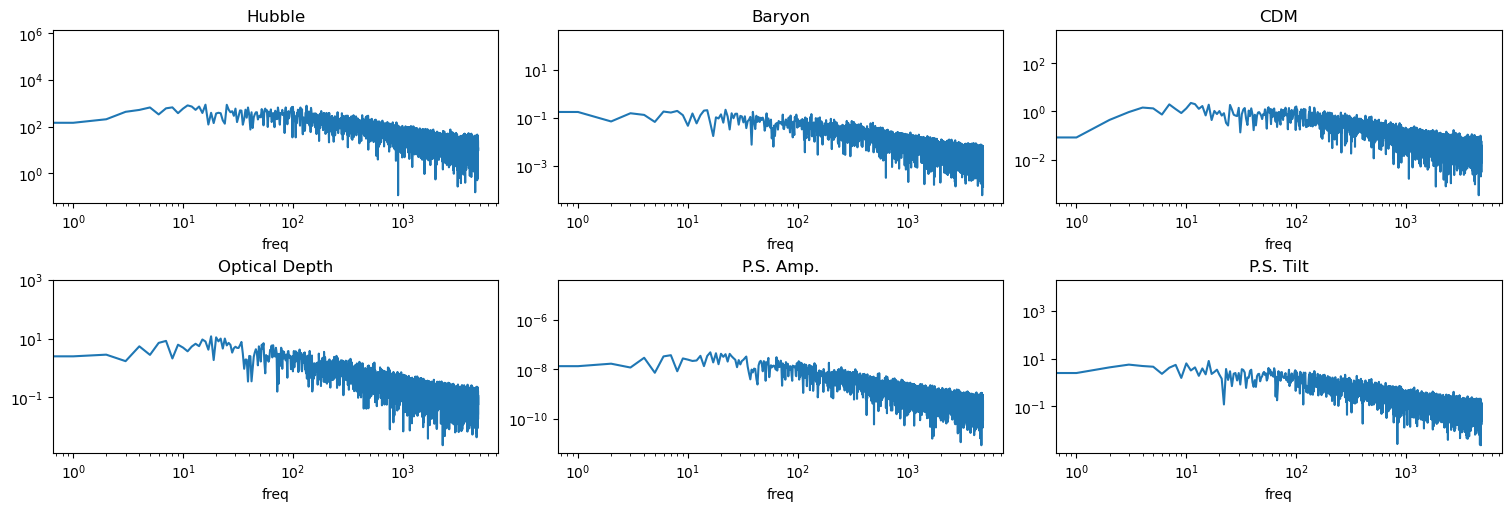

In [274]:
fig = plt.figure(figsize = (15,5),constrained_layout = True)
axes = fig.subplots(2,3).flatten()

for i in np.arange(6):
    axes[i].loglog(np.abs(np.fft.rfft(chain[300:, i])))
    axes[i].set_xlabel('freq')
    axes[i].set_title(f"{p_names[i]}")

## Reasonable rejection rate
Between $20\%-25\%$

In [275]:
# rejected steps
acc_rate = (len(chain) - np.sum(np.logical_and(np.diff(chain[:,0])==0,np.diff(chain[:,1])==0)))/len(chain)

print('Acceptance rate is :', acc_rate)

Acceptance rate is : 0.2003


# Corner Plots

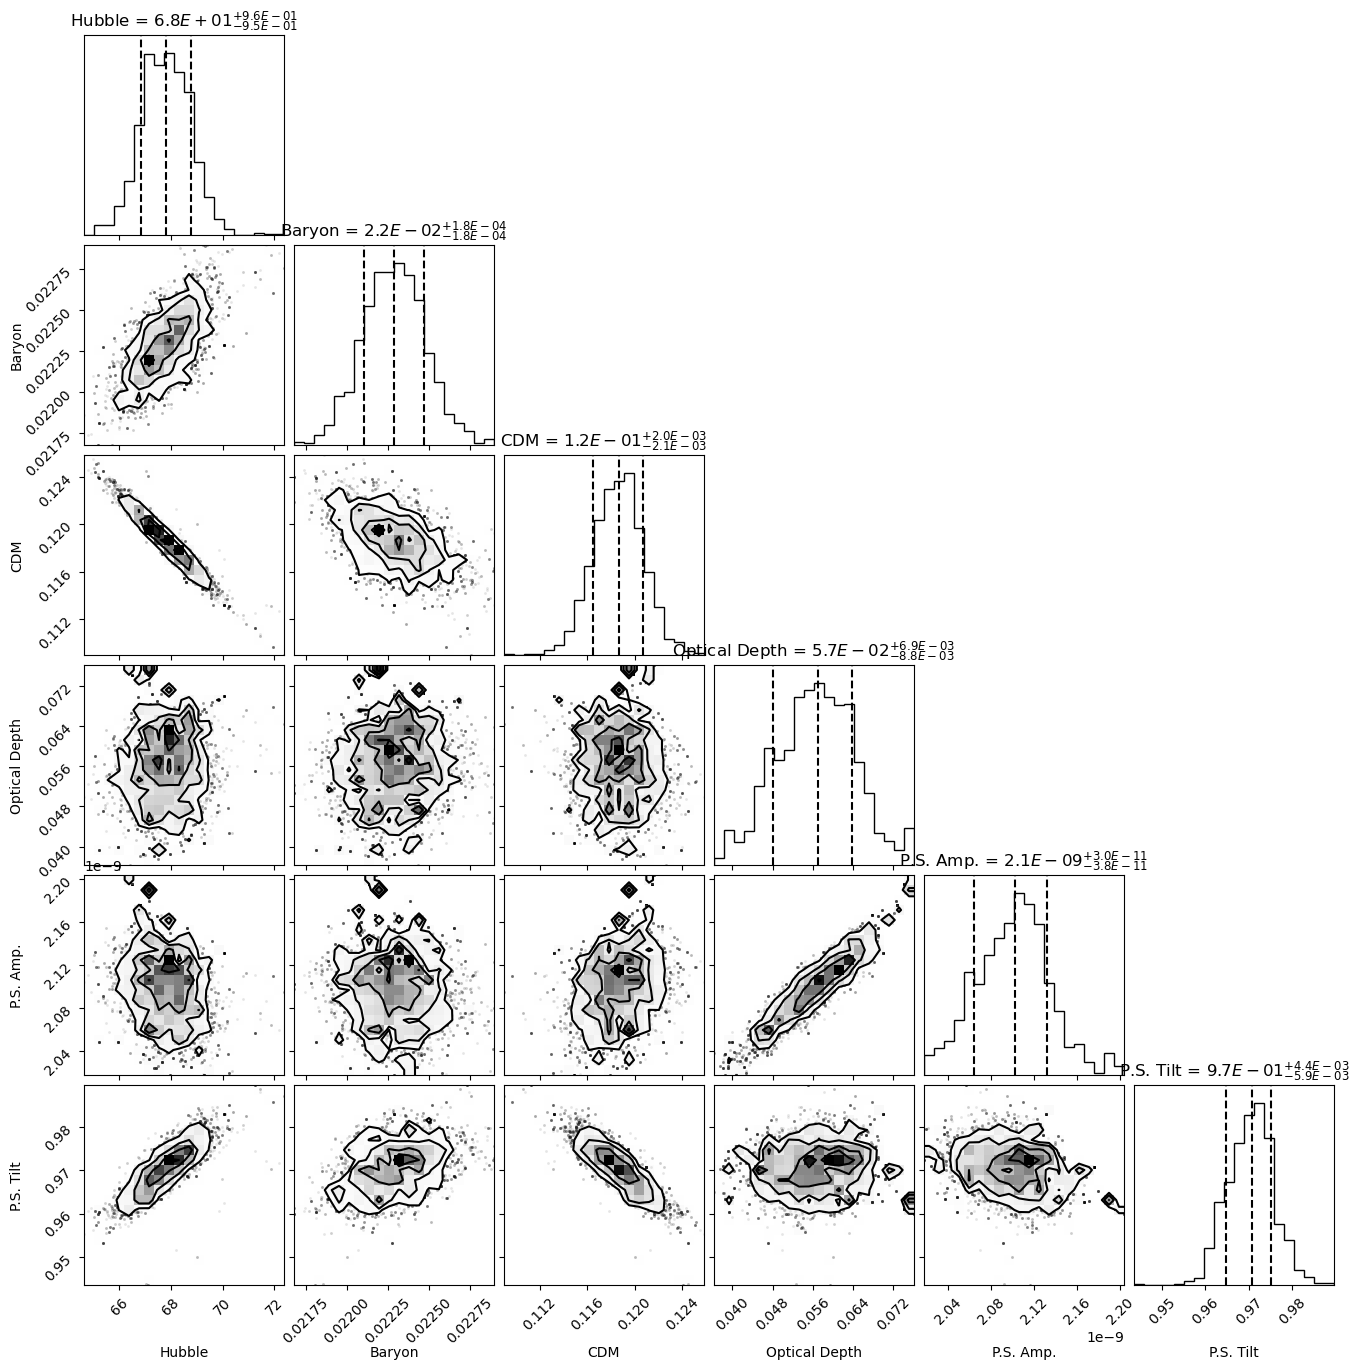

In [276]:
plt.ioff()
corner.corner(chain,
    labels=p_names, quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_fmt = '.1E')

In [277]:
taup = np.mean(chain, axis = 0)
taup_err = np.std(chain,axis = 0)

In [278]:
p_names = ['Hubble', "Baryon", "CDM", "Optical Depth", "P.S. Amp.", "P.S. Tilt"]
print("IMPORTANCE SAMPLING:")
for i, n in enumerate(p_names):
    print(f"\t{n} = ".ljust(20), f"{ip[i]:.2E}", "+/-", f"{ip_err[i]:.2E}")

p_names = ['Hubble', "Baryon", "CDM", "Optical Depth", "P.S. Amp.", "P.S. Tilt"]

print("\n\nNew MCMC:")
for i, n in enumerate(p_names):
    print(f"\t{n} = ".ljust(20), f"{taup[i]:.2E}", "+/-", f"{taup_err[i]:.2E}")


IMPORTANCE SAMPLING:
	Hubble =            6.88E+01 +/- 1.23E+00
	Baryon =            2.25E-02 +/- 2.26E-04
	CDM =               1.17E-01 +/- 2.79E-03
	Optical Depth =     5.49E-02 +/- 6.24E-03
	P.S. Amp. =         2.08E-09 +/- 2.99E-11
	P.S. Tilt =         9.75E-01 +/- 7.06E-03


New MCMC:
	Hubble =            6.78E+01 +/- 9.47E-01
	Baryon =            2.23E-02 +/- 1.89E-04
	CDM =               1.19E-01 +/- 2.13E-03
	Optical Depth =     5.65E-02 +/- 7.72E-03
	P.S. Amp. =         2.10E-09 +/- 3.41E-11
	P.S. Tilt =         9.70E-01 +/- 5.26E-03


# Comparison
The two results agree with each other within their $3\sigma$ intervals. The errorbars are roughly the same.

In [288]:
np.vstack([np.load('obj/tau_chiChain.npy'),np.load('obj/tau_chain.npy').T]).T

(10000, 7)

In [341]:
np.savetxt('planck_chain_tauprior.txt', 
        np.vstack([np.load('obj/tau_chiChain.npy'),np.load('obj/tau_chain.npy').T]).T)

np.savetxt('planck_chain.txt', 
        np.vstack([np.load('obj/chiChain.npy'),np.load('obj/chain.npy').T]).T)


In [344]:
np.loadtxt('planck_chain_tauprior.txt')

array([[3.27220367e+03, 6.90000000e+01, 2.20000000e-02, ...,
        6.00000000e-02, 2.10000000e-09, 9.50000000e-01],
       [3.27220367e+03, 6.90000000e+01, 2.20000000e-02, ...,
        6.00000000e-02, 2.10000000e-09, 9.50000000e-01],
       [3.27220367e+03, 6.90000000e+01, 2.20000000e-02, ...,
        6.00000000e-02, 2.10000000e-09, 9.50000000e-01],
       ...,
       [2.58095968e+03, 6.78226018e+01, 2.21042111e-02, ...,
        4.30829877e-02, 2.03693630e-09, 9.71568803e-01],
       [2.58095968e+03, 6.78226018e+01, 2.21042111e-02, ...,
        4.30829877e-02, 2.03693630e-09, 9.71568803e-01],
       [2.58095968e+03, 6.78226018e+01, 2.21042111e-02, ...,
        4.30829877e-02, 2.03693630e-09, 9.71568803e-01]])